<a href="https://colab.research.google.com/github/navicester/ml-docs/blob/master/ImageRecogniton/Object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Object Localization Project:**

https://medium.com/analytics-vidhya/object-localization-using-keras-d78d6810d0be

---
step by step approach: 
---
1) Detect synthetic white shape over black background

2) Detect a cat over a black background

3) Detect a cat over natural background

4) Detect if there is a cat over natural background

5) detect objects from multiple classes

all data from - https://drive.google.com/drive/folders/1YsxDywjUZi-l_YgzXt__9__eUU-I_6EH?usp=sharing

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.utils import  plot_model
import matplotlib.pyplot as plt

BATCH_SIZE = 64
EPOCH_SIZE = 64

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# First Step

**First Step** - detect synthetic white shape over black background

58889256/58889256 [==============================] - 0s 0us/step


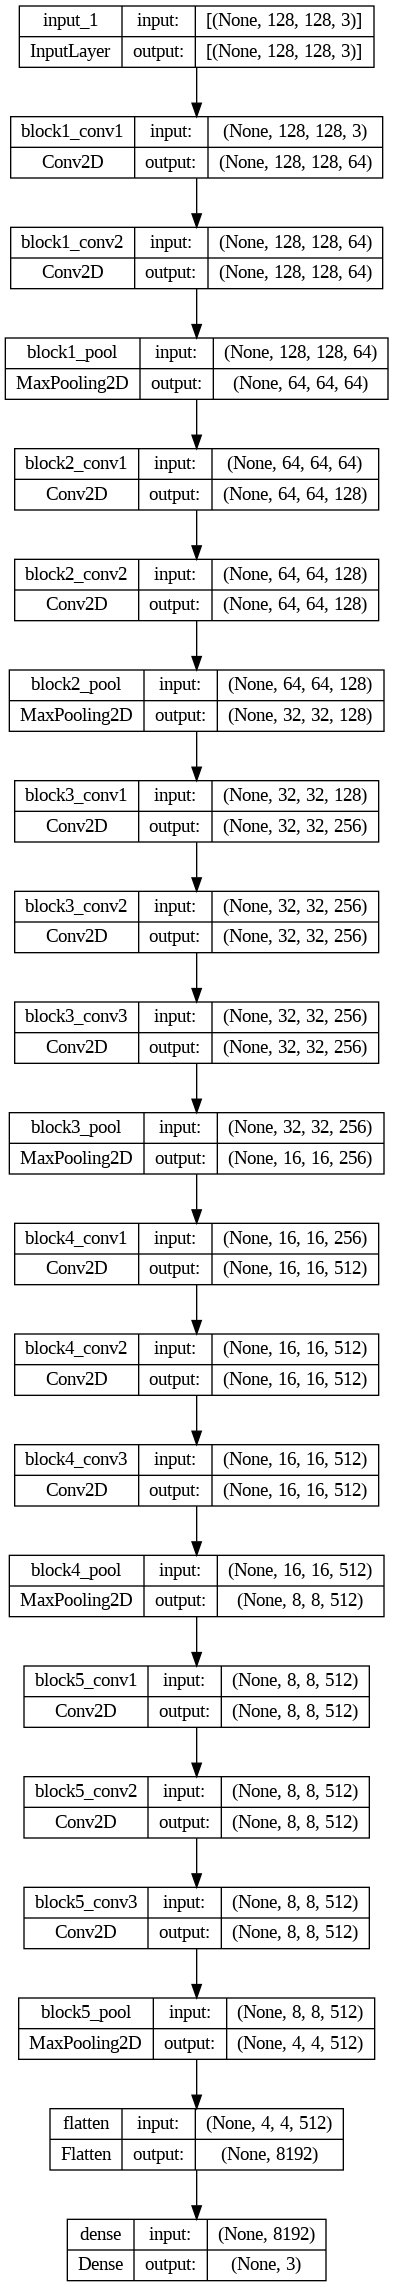

In [ ]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model1 = Model(vgg.input, x)
model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model1, "first_model.png",show_shapes=True,expand_nested=False)

create a circle-generator

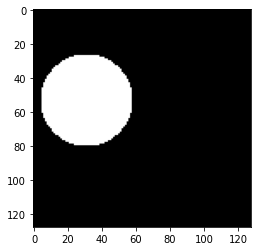

In [ ]:
from matplotlib.patches import Circle

def synthetic_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        x = np.random.randint(8,120)  #圆心
        y = np.random.randint(8,120)
        a = min(128 - max(x,y), min(x,y)) # 离边界距离
        r = np.random.randint(4,a) # 半径
        for x_i in range(128):
          for y_i in range(128):
            if ((x_i - x)**2) + ((y_i - y)**2) < r**2:
              X[i, x_i, y_i,:] = 1 #白色部分，圆形内部
        Y[i,0] = (x-r)/128.
        Y[i,1] = (y-r)/128.
        Y[i,2] = 2*r / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(synthetic_gen())
plt.imshow(x[0])

train the model

In [ ]:
# needs steps per epoch since the generator is infinite
model1.fit_generator(synthetic_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

<ipython-input-5-719ab3f945c8>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1.fit_generator(synthetic_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)


Epoch 1/5
64/64 [==============================] - 76s 893ms/step - loss: 0.5947
Epoch 2/5
64/64 [==============================] - 58s 907ms/step - loss: 0.4915
Epoch 3/5
64/64 [==============================] - 58s 912ms/step - loss: 0.4908
Epoch 4/5
64/64 [==============================] - 57s 896ms/step - loss: 0.4905
Epoch 5/5
64/64 [==============================] - 58s 910ms/step - loss: 0.4929


predict results

2/2 [==============================] - 2s 12ms/step


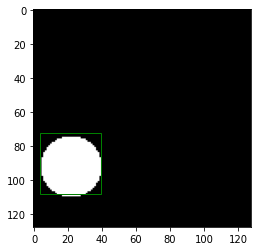

In [ ]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(synthetic_gen())
# predict
pred = model1.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)


# Second Step

**Second Step**-detect a cat over a black background

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


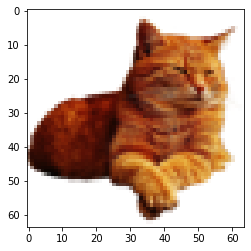

(64, 64, 4)

In [ ]:
from PIL import Image

cat_pil = Image.open("/content/drive/MyDrive/data/cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()


cat.shape

create a cat generator

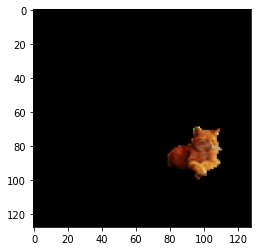

In [ ]:
from matplotlib.patches import Circle

def cat_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        bg = Image.new('RGB', (128, 128))

        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        h = cat_x
        w = cat_y

        bg.paste(temp_cat, (x1, y1))
        cat = np.asarray(bg) / 255.
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(cat_gen())
plt.imshow(x[0])

create a model

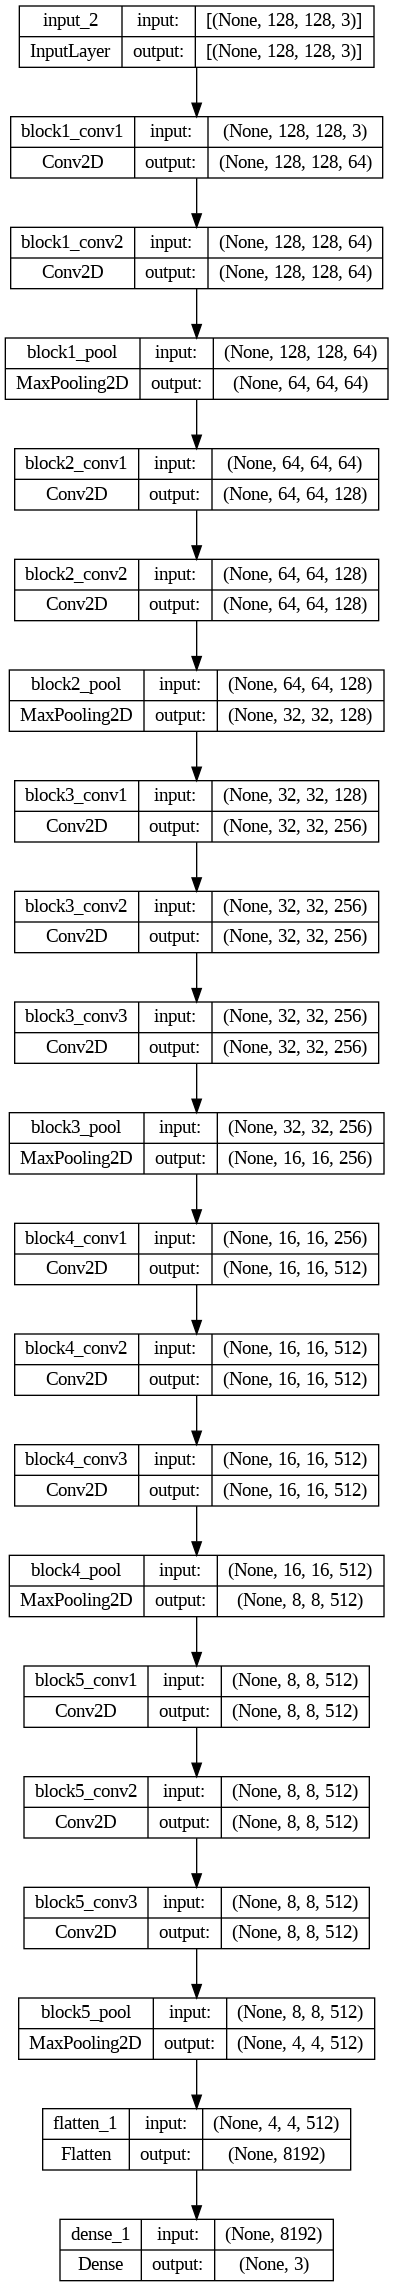

In [ ]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model2 = Model(vgg.input, x)
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model2, "second_model.png",show_shapes=True)

train

In [ ]:
# needs steps per epoch since the generator is infinite
model2.fit_generator(cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

<ipython-input-12-661524cc16fa>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)


Epoch 1/5
64/64 [==============================] - 21s 239ms/step - loss: 0.6446
Epoch 2/5
64/64 [==============================] - 15s 242ms/step - loss: 0.5793
Epoch 3/5
64/64 [==============================] - 16s 245ms/step - loss: 0.5757
Epoch 4/5
64/64 [==============================] - 16s 247ms/step - loss: 0.5751
Epoch 5/5
64/64 [==============================] - 16s 251ms/step - loss: 0.5732


predict results

2/2 [==============================] - 0s 65ms/step


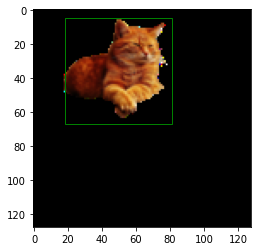

In [ ]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(cat_gen())
# predict
pred = model2.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)

# Third Step

**Third Step** - detect a cat over natural background

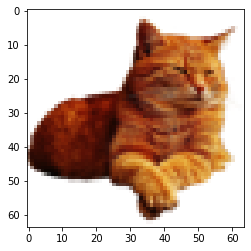

(64, 64, 4)

In [ ]:
from PIL import Image

cat_pil = Image.open("/content/drive/MyDrive/data/cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()


cat.shape

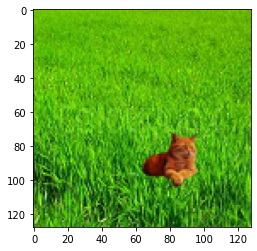

In [ ]:
def natural_cat_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        # background image
        bg_name = f'/content/drive/MyDrive/data/bg{np.random.randint(1,4)}.jpg'
        bg = Image.open(bg_name)

        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        h = cat_x
        w = cat_y

        bg.paste(temp_cat, (x1, y1),mask=temp_cat)
        cat = np.asarray(bg) / 255.
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(natural_cat_gen())
plt.imshow(x[0])

create model3

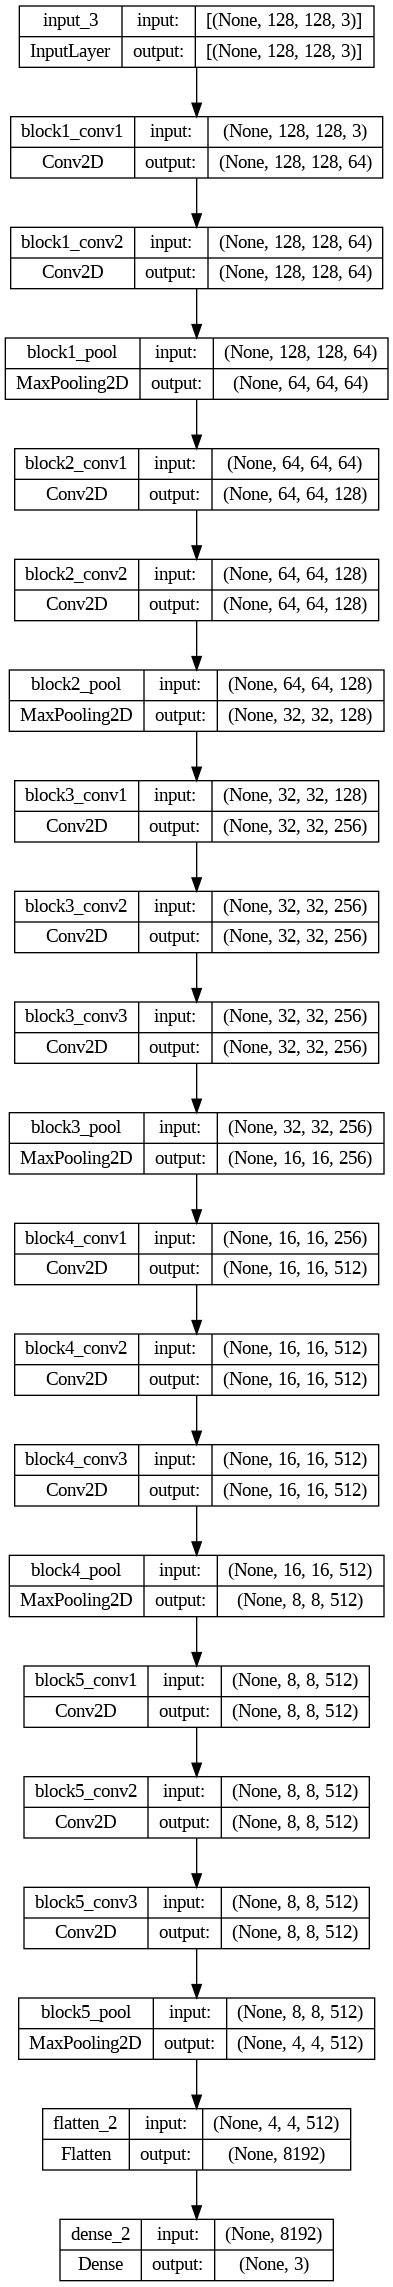

In [ ]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model3 = Model(vgg.input, x)
model3.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model3, "third_model.png",show_shapes=True)

train model3

In [ ]:
# needs steps per epoch since the generator is infinite
model3.fit_generator(natural_cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

Epoch 1/5


<ipython-input-19-d557991f70c6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3.fit_generator(natural_cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)


64/64 [==============================] - 21s 260ms/step - loss: 0.8873
Epoch 2/5
64/64 [==============================] - 16s 258ms/step - loss: 0.6084
Epoch 3/5
64/64 [==============================] - 17s 260ms/step - loss: 0.5780
Epoch 4/5
64/64 [==============================] - 17s 266ms/step - loss: 0.5735
Epoch 5/5
64/64 [==============================] - 17s 264ms/step - loss: 0.5764


examine results

2/2 [==============================] - 0s 57ms/step


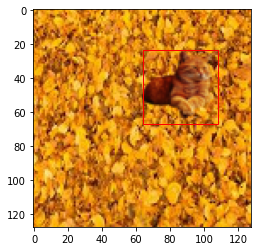

In [ ]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(natural_cat_gen())
# predict
pred = model3.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)

# Fourth Step

**fourth step** - detect if there is a cat over a natural background

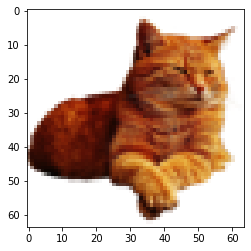

(64, 64, 4)

In [ ]:
from PIL import Image

cat_pil = Image.open("/content/drive/MyDrive/data/cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()

cat.shape

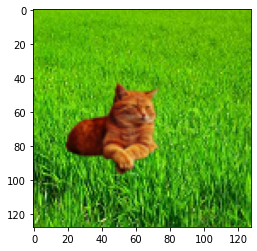

In [ ]:
def natural_cat_gen2(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 4))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        # background image
        bg_name = f'/content/drive/MyDrive/data/bg{np.random.randint(1,4)}.jpg'
        bg = Image.open(bg_name)

        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        h = cat_x
        w = cat_y
        # draw the cat with probability 0.8
        cat_appear = 0.0
        if(np.random.uniform(low=0.0,high=1.0) < 0.8):
          cat_appear = 1.0
          bg.paste(temp_cat, (x1, y1),mask=temp_cat)
        cat = np.asarray(bg) / 255.
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
        Y[i,3] = cat_appear
      yield X, Y

# sanity check - plot the images
x,y = next(natural_cat_gen2())
plt.imshow(x[0])

We can still use crossentropy as a loss but we need to pay attention:
When there is no cat, a vanilla crossentropy will still take into account the predictions for the bounding box. To avoid this, we will create a custom loss:

In [ ]:
def custom_loss(y_true, y_pred):
  # y_true shape is [BATCH, 4], 
  # y_true[:,:3] -> location
  # y_true[:,-1] -> is there a cat

  location_bce = tf.keras.losses.binary_crossentropy(y_true[:, :3], y_pred[:, :3])
  is_there_bce = tf.keras.losses.binary_crossentropy(y_true[:, -1], y_pred[:, -1])

  return (location_bce * y_true[:, -1]) + is_there_bce

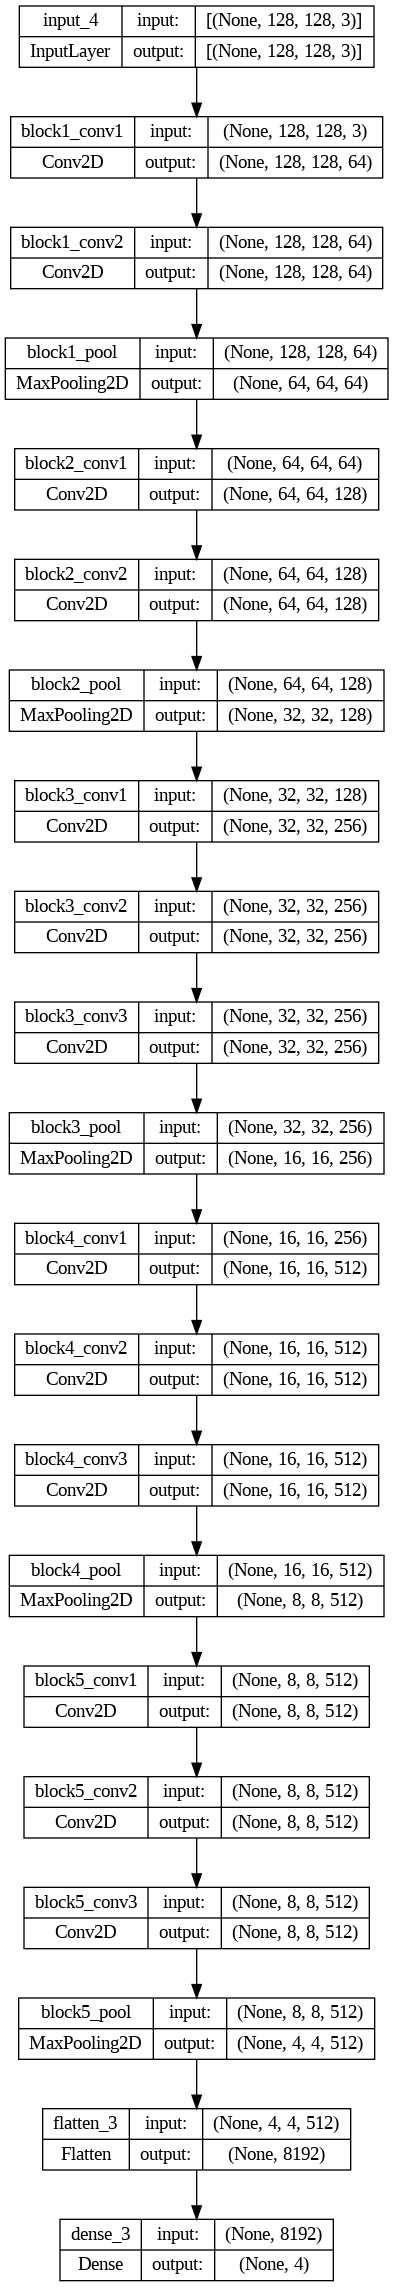

In [ ]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model4 = Model(vgg.input, x)
model4.compile(loss=custom_loss, optimizer=Adam(lr=0.001))
# plot the model
plot_model(model4, "fourth_model.png",show_shapes=True)

In [ ]:
# needs steps per epoch since the generator is infinite
model4.fit_generator(natural_cat_gen2(),steps_per_epoch=EPOCH_SIZE,epochs=5)

Epoch 1/5


<ipython-input-27-294009ef4f4e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4.fit_generator(natural_cat_gen2(),steps_per_epoch=EPOCH_SIZE,epochs=5)


64/64 [==============================] - 21s 250ms/step - loss: 1.0765
Epoch 2/5
64/64 [==============================] - 16s 250ms/step - loss: 0.4866
Epoch 3/5
64/64 [==============================] - 16s 250ms/step - loss: 0.4604
Epoch 4/5
64/64 [==============================] - 16s 250ms/step - loss: 0.4581
Epoch 5/5
64/64 [==============================] - 16s 253ms/step - loss: 0.4580


2/2 [==============================] - 0s 58ms/step


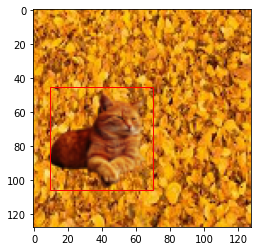

In [ ]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  if(p[3]>0.5):
    rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(natural_cat_gen2())
# predict
pred = model4.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)

# Fifth Step

**Fifth Step** - detect objects from multiple classes

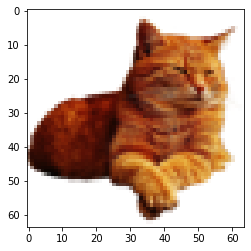

cat.shape = (64, 64, 4)


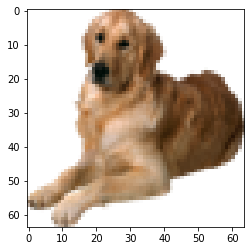

dog.shape = (64, 64, 4)


In [ ]:
from PIL import Image

# load cat 
cat_pil = Image.open("/content/drive/MyDrive/data/cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()

print(f'cat.shape = {cat.shape}')

# load dog
dog_pil = Image.open("/content/drive/MyDrive/data/dog.png")
dog_pil = dog_pil.resize((64,64))
dog = np.asarray(dog_pil)
plt.imshow(dog)
plt.show()

print(f'dog.shape = {dog.shape}')

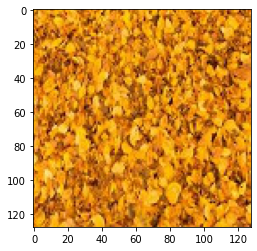

In [ ]:
def flip_coin():
  if np.random.uniform()>0.5:
    return 'cat'
  return 'dog'

def natural_cat_dog_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 6))
      # fill each image
      for i in range(batch_size):
        size = np.random.randint(32,64)
        # choose cat or dog
        cat = 0.0
        dog = 0.0
        if(flip_coin() == 'cat'):
          # resize the cat
          temp_im = cat_pil.resize((size,size))
          temp_im_np = np.asarray(temp_im) / 255.
          animal_x, animal_y, _ = temp_im_np.shape
          cat = 1.0
        else:
          temp_im = dog_pil.resize((size,size))
          temp_im_np = np.asarray(temp_im) / 255.
          animal_x, animal_y, _ = temp_im_np.shape
          dog = 1.0

        # background image
        bg_name = f'/content/drive/MyDrive/data/bg{np.random.randint(1,4)}.jpg'
        bg = Image.open(bg_name)

        x1 = np.random.randint(1,128 - animal_x)
        y1 = np.random.randint(1,128 - animal_y)
        h = animal_x
        w = animal_y
        # draw the cat with probability 0.8
        animal_appear = 0.0
        if(np.random.uniform(low=0.0,high=1.0) < 0.8):
          animal_appear = 1.0
          bg.paste(temp_im, (x1, y1),mask=temp_im)
        pic = np.asarray(bg) / 255.
        X[i] = pic

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = animal_x / 128.
        Y[i,3] = animal_appear * cat // 1 # is_cat
        Y[i,4] = animal_appear * dog // 1 # is_dog
        Y[i,5] = (1. - animal_appear) // 1

      yield X, Y

# sanity check - plot the images
x,y = next(natural_cat_dog_gen())
plt.imshow(x[0])

# print(y[:, 3:])

In [ ]:
def custom_loss2(y_true, y_pred):
  # y_true shape is [BATCH, 6], 
  # y_true[:,:3] -> location
  # y_true[:,3] -> is there a cat
  # y_true[:,4] -> is there a dog
  # y_true[:,5] -> is there a void

  location_bce = tf.keras.losses.binary_crossentropy(y_true[:, :3], y_pred[:, :3])
  cls_cce = tf.keras.losses.categorical_crossentropy(y_true[:, 3:], y_pred[:, 3:])

  is_animal = 1 - (y_true[:, -1])

  return (location_bce * is_animal) + 5 * cls_cce

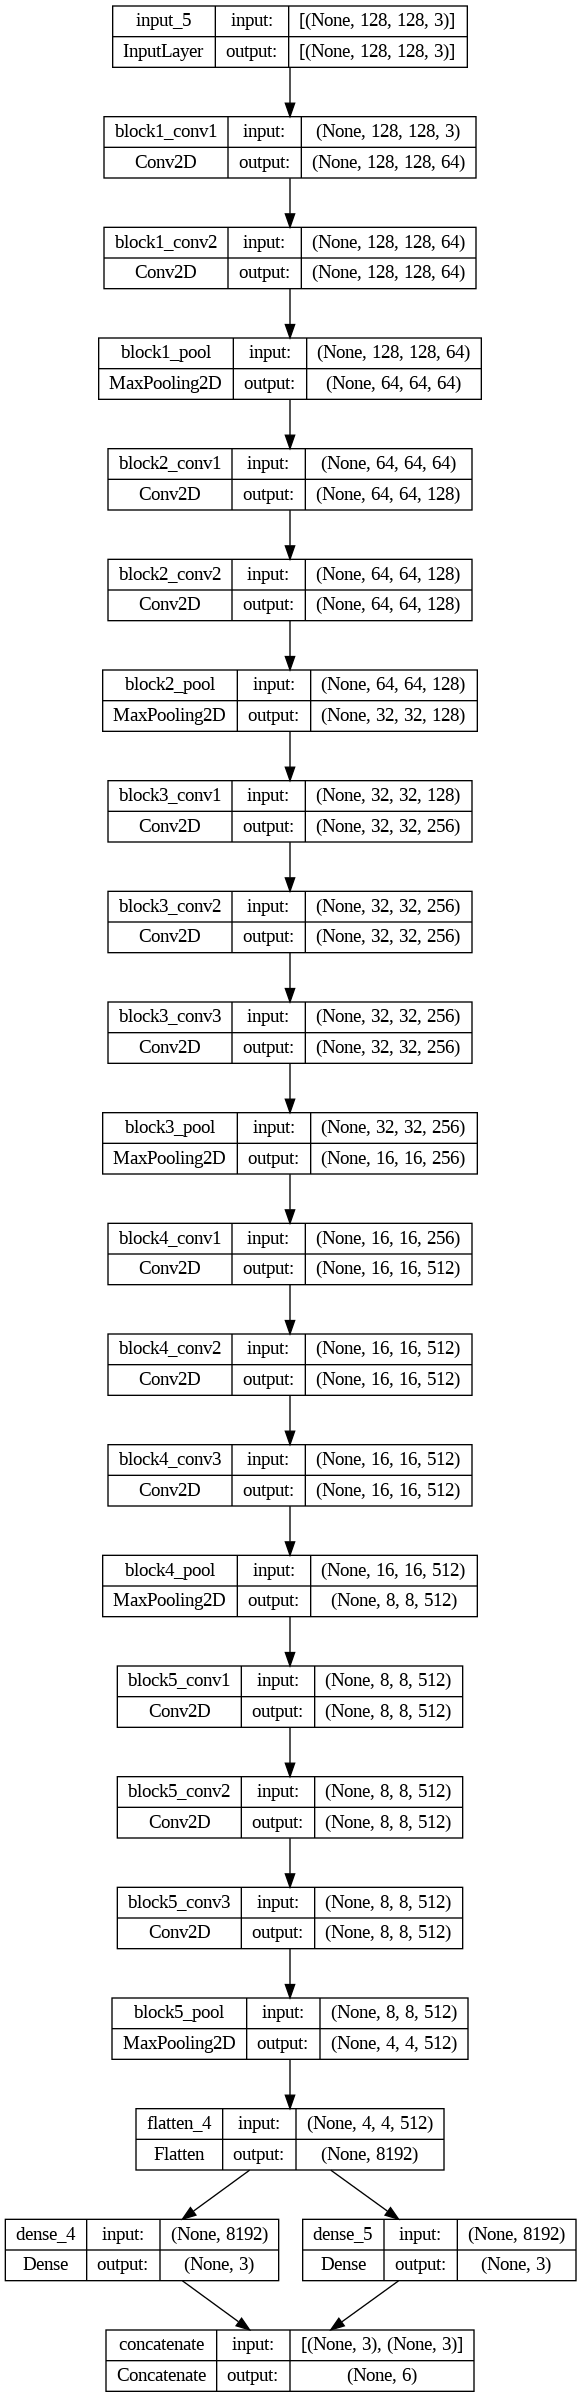

In [ ]:
from tensorflow.keras.layers import Concatenate

# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x1 = Dense(3, activation='sigmoid')(x)
x2 = Dense(3, activation='softmax')(x)
out = Concatenate()([x1, x2])
model5 = Model(vgg.input, out)
model5.compile(loss=custom_loss2, optimizer=Adam(lr=0.001))
# plot the model
plot_model(model5, "fifth.png",show_shapes=True)

In [ ]:
# needs steps per epoch since the generator is infinite
model5.fit_generator(natural_cat_dog_gen(),steps_per_epoch=10*EPOCH_SIZE,epochs=5)

Epoch 1/5


<ipython-input-35-0938d8b4115f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model5.fit_generator(natural_cat_dog_gen(),steps_per_epoch=10*EPOCH_SIZE,epochs=5)


640/640 [==============================] - 165s 248ms/step - loss: 52.3908
Epoch 2/5
640/640 [==============================] - 163s 254ms/step - loss: 52.2531
Epoch 3/5
640/640 [==============================] - 164s 256ms/step - loss: 52.3164
Epoch 4/5
640/640 [==============================] - 164s 256ms/step - loss: 52.6424
Epoch 5/5
640/640 [==============================] - 164s 256ms/step - loss: 52.5064


2/2 [==============================] - 0s 53ms/step


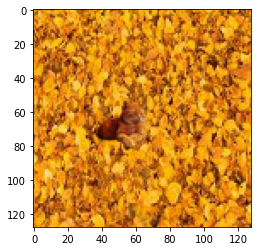

In [ ]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  if(np.argmax(p[3:])==0): # cat
    rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  elif(np.argmax(p[3:])==1): # dog
    rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=2,edgecolor='y',facecolor='none')
    ax.add_patch(rect)
  plt.show()


# generate new image
x, y = next(natural_cat_dog_gen())
# predict
pred = model5.predict(x)
# examine 1 image
im = x[0]
p = pred[0]

plot_pred(im,p)